In [1]:
import sys
print(sys.executable)

/home/phinguyen/projects/mlflow_practice_01/venv/bin/python


In [2]:
!python --version

Python 3.10.13


In [3]:
import pandas as pd
import numpy as np

def load_data(path):
    data = pd.read_csv(path)
    return data

data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after droping na values \n")
    print(data.isna().sum())
    return data

def preprocessing(data):
    data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
    
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    
    final_data=data[to_keep]
    
    
    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    return final_data

def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
 
    return X_train, y_train

def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [5]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [6]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [7]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')
cleaned_data = data_cleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after droping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [8]:
final_data = preprocessing(cleaned_data)
final_data.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,False,False,False,False,True,False,False,False,True,False
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,False,False,True,False,False,False,False,False,True,False
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,False,False,False,False,True,False,False,False,False,True
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,False,False,True,False,False,False,False,False,True,False
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,False,False,True,False,False,False,False,False,False,True


In [9]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [10]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [11]:
model = training_basic_classifier(X_train,y_train)

In [12]:
y_pred = predict_on_test_data(model,X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)
y_pred_prob

array([[0.98019802, 0.01980198],
       [0.98019802, 0.01980198],
       [0.92079208, 0.07920792],
       ...,
       [1.        , 0.        ],
       [0.72277228, 0.27722772],
       [1.        , 0.        ]])

In [14]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
run_metrics

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.53, 'entropy': 0.21}

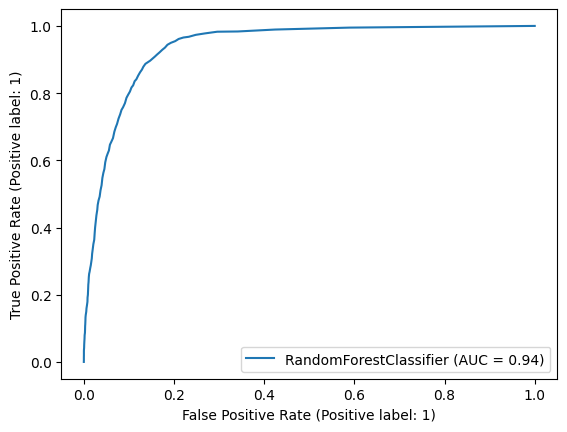

In [15]:
create_roc_auc_plot(model, X_test, y_test)

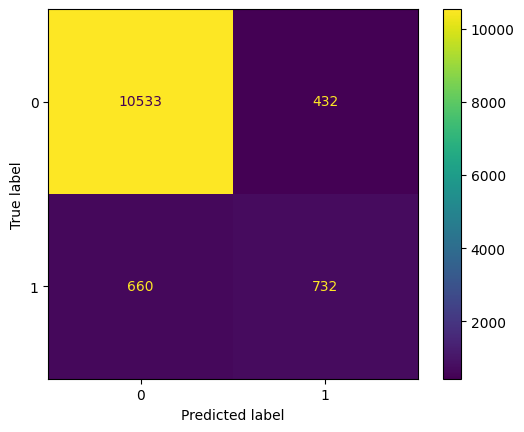

In [16]:
create_confusion_matrix_plot(model, X_test, y_test)

# MLflow

In [22]:
experiment_name = "basic_classifier_02"
run_name = "term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.53, 'entropy': 0.21}


In [24]:
create_experiment(experiment_name, run_name, run_metrics, model, 'confusion_matrix.png', 'roc_auc_curve.png')

Run - term_deposit is logged to experiment basic_classifier_02


#### Function to create an experiment in MLflow and log parameters, metrics & artifact files like images etc.

In [18]:
from typing import Dict
from sklearn.base import BaseEstimator
import mlflow

def create_experiment(experiment_name: str, 
                      run_name: str, 
                      run_metrics: Dict,
                      model: BaseEstimator,
                      confusion_matrix_path=None,
                      roc_auc_plot_path=None,
                      run_params=None):
    mlflow.set_experiment(experiment_name=experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
        
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, "Confusion_matrix")
        
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2": "Randomized Search CV", "tag3": "Production"})
    
    print(f'Run - {run_name} is logged to experiment {experiment_name}')

In [21]:
create_experiment(experiment_name, run_name, run_metrics, model, 'confusion_matrix.png', 'roc_auc_curve.png')

2023/12/09 17:45:36 INFO mlflow.tracking.fluent: Experiment with name 'basic_classifier' does not exist. Creating a new experiment.


Run - term_deposit is logged to experiment basic_classifier


#### Create another experiment after tuning hyper-parameters and log the best parameters for which model gives the optimal performance

In [25]:
experiment_name = "optimized_model"
run_name = "random_search_cv_tuned_model"
model_tuned, best_params = hyper_parameter_tuning(X_train=X_train, y_train=y_train)
run_params = best_params

y_pred = predict_on_test_data(model=model_tuned, X_test=X_test)
y_pred_prob = predict_prob_on_test_data(model=model_tuned, X_test=X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

for param in run_params:
    print(param, run_params[param])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   1.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   2.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   2.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   2.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   2.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=21; total t

/home/phinguyen/projects/mlflow_practice_01/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
98 fits failed with the following error:
Traceback (most recent call last):
  File "/home/phinguyen/projects/mlflow_practice_01/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/phinguyen/projects/mlflow_practice_01/venv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/phinguyen/projects/mlflow_practice_01/venv/lib/python3.10/site-pa

Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}  

n_estimators 21
min_samples_split 2
min_samples_leaf 1
max_features sqrt
max_depth 80
bootstrap True


In [26]:
create_experiment(experiment_name, run_name, run_metrics, model_tuned, 'confusion_matrix.png', 'roc_auc_curve.png', run_params)

2023/12/09 18:32:01 INFO mlflow.tracking.fluent: Experiment with name 'optimized_model' does not exist. Creating a new experiment.


Run - random_search_cv_tuned_model is logged to experiment optimized_model


/home/phinguyen/projects/mlflow_practice_01/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/phinguyen/projects/mlflow_practice_01/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
